## Ehancement - Time between Events

Enhancement is the last element in the trifecta of discovery, conformance, and enhancement that is process mining, as can be seen in the PM<sup>2</sup> methdodolgy <sup>[1]</sup>.

Enhancement also seems to have the least focus in academic literature. Enhacement investigations focus on how the attributes effect the processes in the event log. In the literatrure the most commnly researched atttribute is the resource. The resource is the indvidual,team or organisation repsonsble for an activity. In our event log we dont have a resource as the job cycle follows a single ambulance so the "resource" is constant for all activities. We can however look at the second focus of enhancement investigations which is the timing between events and how attributes effect these.

[1]Van Eck, M. L., Lu, X., Leemans, S. J. & Van Der Aalst, W. M. (2015), Pm: a process mining project
methodology, in ‘International conference on advanced information systems engineering’, Springer, pp. 297–
313.

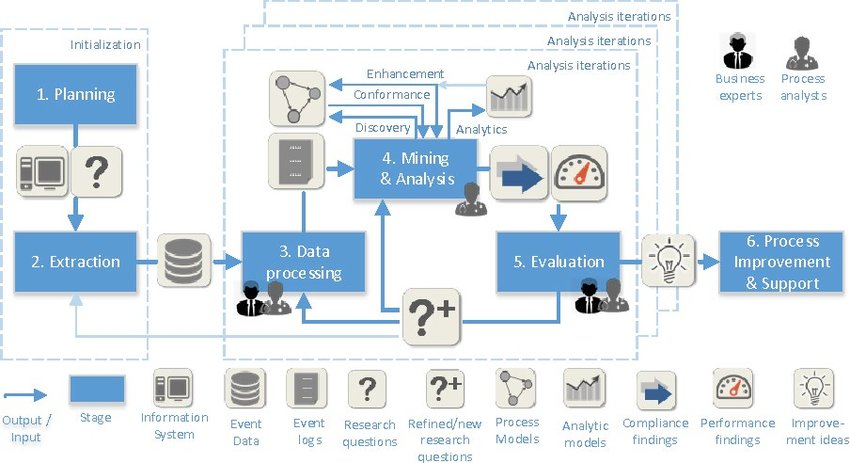

In [71]:
from IPython.display import Image, display
display(Image(filename='PM2_Process-Mining-Project-Methodology.png'))

In python we import open source packages with useful functions that will facillitate our programming

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

We download our pre-prepared event log

In [4]:
EL_df0=pd.read_csv('EventLogWAttsBusRules.csv')
EL_df0[['Timestamp']] = EL_df0[['Timestamp']].apply(pd.to_datetime, errors='coerce')
EL_df0.Patient_ID.nunique()

We are going to perform some transformatins on our event log so it is smart to make a copy now so that we can revert any changes to if required by rerunning the below cell.

In [8]:
EL_df1=EL_df0.copy()

## Calculate time since start of case for each event 

As we are intersted in the timings between each event, in the below cells we calculate each events respective time from the start its case so that we can work out the difference in time between events easily.

In [9]:
case_starts_ends = EL_df1.pivot_table(index='Patient_ID', aggfunc={'Timestamp': ['min', 'max']})# find mininum and maximum time of each patient
case_starts_ends = case_starts_ends.reset_index() #rest index to not be patient
case_starts_ends.columns = ['Patient_ID', 'caseend', 'casestart'] # rename columns

In [10]:
EL_df1 = EL_df1.merge(case_starts_ends, on='Patient_ID') # merge tales on index patient
EL_df1['caselength'] = EL_df1['caseend'] - EL_df1['casestart']
EL_df1['relativetime'] = EL_df1['Timestamp'] - EL_df1['casestart']
EL_df1['relativetime_s'] = EL_df1['relativetime'].dt.seconds + 86400*EL_df1['relativetime'].dt.days
EL_df1['caselength']=EL_df1['caselength'].dt.seconds + 86400*EL_df1['caselength'].dt.days

At this time we can add some additional attributes to the event log so that we can observe their effect on the process. Here we add the hour in the day of each event to the event log as well as the day in the week to see if having processes or activities on different hours or days affects the process.

In [11]:
EL_df1['hour'] = EL_df1['Timestamp'].apply(lambda x: x.time().hour)
EL_df1['day'] = EL_df1['Timestamp'].dt.dayofweek

Name days

In [12]:
EL_df1['day'] = np.where(EL_df1['day'] == 0, 'Monday',EL_df1['day'])
EL_df1['day'] = np.where(EL_df1['day'] == '1', 'Tuesday',EL_df1['day'])
EL_df1['day'] = np.where(EL_df1['day'] == '2', 'Wednesday',EL_df1['day'])
EL_df1['day'] = np.where(EL_df1['day'] == '3', 'Thursday',EL_df1['day'])
EL_df1['day'] = np.where(EL_df1['day'] == '4', 'Friday',EL_df1['day'])
EL_df1['day'] = np.where(EL_df1['day'] == '5', 'Saturday',EL_df1['day'])
EL_df1['day'] = np.where(EL_df1['day'] == '6', 'Sunday',EL_df1['day'])

If we are interesed in the timimngs of specific activitities or events of the processes in the log we can add these as a seperate column. Here we hypothesise that the hour the incident is called in and the hour that the ambulance arrives on scene might effect further timings between events in the process.

In [13]:
Incidenthour=EL_df1[EL_df1.Activity=='Incident_Time'][['Patient_ID','hour']]
Incidenthour['Incident_Hour']=Incidenthour['hour']
Incidenthour=Incidenthour.drop('hour',axis=1)
EL_df1=EL_df1.merge(Incidenthour,left_on=['Patient_ID'],right_on=['Patient_ID'],how='left')

In [14]:
arrivescenehour=EL_df1[EL_df1.Activity=='Arrive_scene'][['Patient_ID','hour']]
arrivescenehour['Arrive_on_Scene_Hour']=arrivescenehour['hour']
arrivescenehour=arrivescenehour.drop('hour',axis=1)
EL_df1=EL_df1.merge(arrivescenehour,left_on=['Patient_ID'],right_on=['Patient_ID'],how='left')

In [16]:
EL_df1=EL_df1[~EL_df1.Patient_ID.isin(list(set(EL_df1[EL_df1.relativetime_s >24*60*60].Patient_ID.values)))]

## Repetitive Graph Functions

We are going to prodewuce similar graphs and tables while analysing the effect of multiple attributes on the process so here we defne them ahead of time to spped up our workflow.

This fucntion calculates the time between two specified events

In [17]:
def timebetweenevents(df,first_activity,second_activity):
    activity1df=df[df['Activity']==first_activity]
    activity2df=df[df['Activity']==second_activity]
    mergeddf=activity1df.merge(activity2df,on=['Patient_ID'],how='right')
    mergeddf=mergeddf[['Patient_ID','Activity_x','Timestamp_x','relativetime_s_x','Activity_y','Timestamp_y','relativetime_s_y']].copy()
    mergeddf['diff']=mergeddf['relativetime_s_y']-mergeddf['relativetime_s_x']
    #inds = mergeddf['diff'].index[mergeddf['diff'].apply(np.isnan)]
    time=mergeddf['diff'][~mergeddf['diff'].isna()].values
    timemins = [x / (60) for x in time]
    return timemins

This fucntion produces a time density box plot for the time between two specified events

In [18]:
def timedensityandboxplot(df,first_activity,second_activity,Title,upperxlim):
    timemins=timebetweenevents(df,first_activity,second_activity)
    f, (ax_dens,ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
    sns.kdeplot(timemins,ax=ax_dens)
    sns.boxplot(timemins,ax=ax_box , orient="h",showmeans=True, meanprops={"marker": "+","markeredgecolor": "orange","markersize": "10"})
    plt.xlim(0,upperxlim)
    ax_dens.set(xlabel='')
    ax_dens.set(title=Title)
    ax_box.set(xlabel='Time (Minutes)')
    plt.show()
    return print("median time between events", np.median(timemins)),print("mean time between events", np.mean(timemins))

This fucntion produces a boxplot to compare the time between two specified events on a named atribute with an optional condition to specify the outcome attribute

In [19]:
def boxplot_time_between_activities_per_attribute(DF,first_activity,second_activity,attribute,specify_outcome_required,Title,lowerylim,upperylim):
    ELTT=DF[~DF[attribute].isna()]

    if specify_outcome_required!='None':
        ELTT=ELTT[ELTT['Outcome']==specify_outcome_required]
    cats=list(sorted(set(ELTT[attribute].values)))
    catsdict={key:None for key in cats}
    for i in range(len(cats)):
        cat=cats[i]
        df=[]
        df=ELTT[ELTT[attribute]==cat]
        timemins=timebetweenevents(df,first_activity,second_activity)
        catsdict[cat]=timemins
    catsdf=pd.DataFrame(dict([(k,pd.Series(v)) for k, v in catsdict.items()]))
    plt.figure(figsize=(30,5))
    sns.boxplot(data=catsdf).set(title=Title,ylabel='Time (Minutes)',xlabel=attribute)
    plt.ylim(lowerylim,upperylim)
    

This fucntion calculates the mean effect on time between specified activities by a specified attribute

In [20]:
def attributes_effect_on_mean_time_between_events(df,activity1,activity2,attribute,specify_outcome_required):
    meantimes=[]
    attributevals=[]
    DF=df[~df[attribute].isna()]
    if specify_outcome_required!='None':
        DF=DF[DF['Outcome']==specify_outcome_required]
    time=timebetweenevents(DF,activity1,activity2)
    print('Mean Time between'+activity1+' and '+ activity2 + ' was ' + str(np.mean(time))+' minutes')
    for  i in set(DF[attribute].values):
        df=[]
        df=DF[DF[attribute]==i]
        meantimes.append(np.mean(timebetweenevents(df,activity1,activity2)))
        attributevals.append(i)
    columnname=('Mean effect on mean time between '+activity1+' and '+activity2+ ' (minutes)')
    attefffect={attribute:attributevals, columnname:[-1*(np.mean(time)-i) for i in meantimes]}
    attefffect_df = pd.DataFrame(attefffect)
    attefffect_df=attefffect_df.sort_values( columnname,axis=0, ascending=False)
    return(attefffect_df)


## Analysis

We focues on the three main areas of interest in the job cycle, these are resposne time, time spent on scene and the handover time.

### Incident to Arrive on Scene (Response Time)

First we view the time density graph between the events.

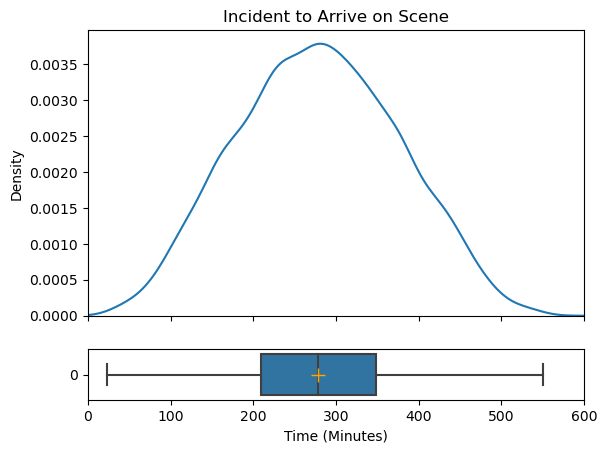

median time between events 278.0
mean time between events 278.7954001839926


(None, None)

In [30]:
timedensityandboxplot(EL_df1,'Incident_Time','Arrive_scene','Incident to Arrive on Scene',600)

We observe the effect of the geographical sub domain decile on the timing between the events

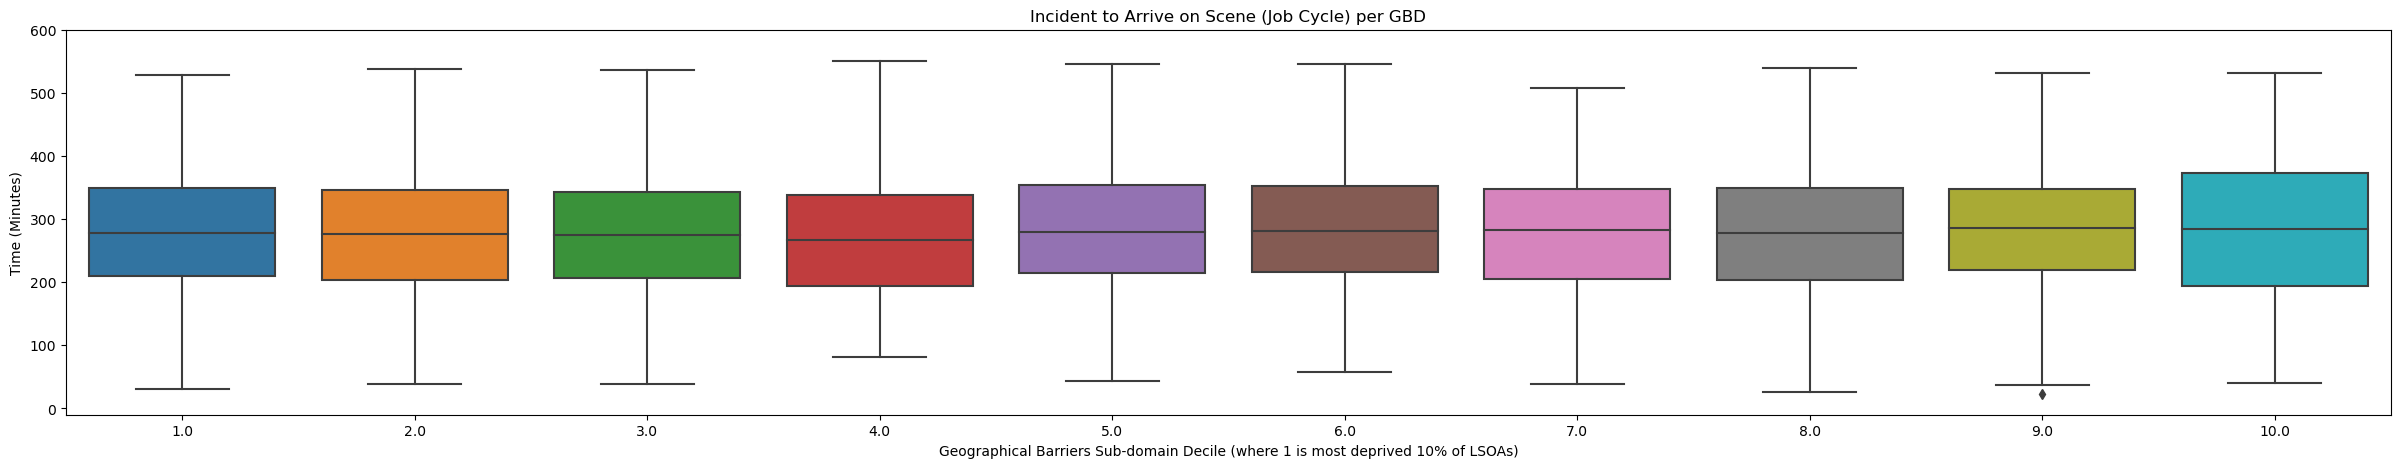

In [32]:
boxplot_time_between_activities_per_attribute(EL_df1,'Incident_Time','Arrive_scene','Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)','None','Incident to Arrive on Scene (Job Cycle) per GBD',-10,600)

### Arrive on Scene to Depart Scene

With the time spent on scene, we might be interested in whether the qualification of the highest qualifed crew memeber effects the time spent on scene. We hypothesise that the time spent on scene is probebly where the ambucalce crew has the most control over the process.

First we view the time density graph between the events.

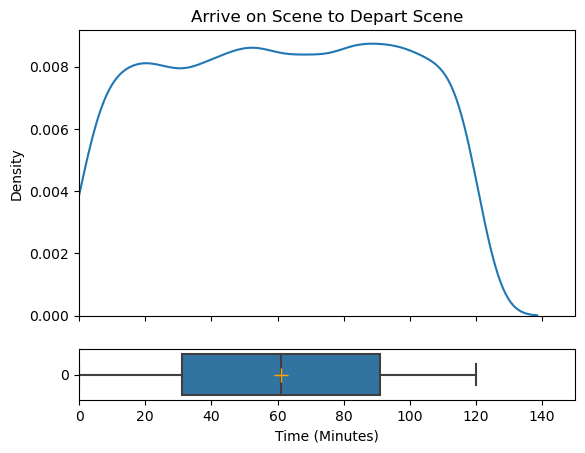

median time between events 61.0
mean time between events 60.999816007359705


(None, None)

In [143]:
timedensityandboxplot(EL_df1,'Arrive_scene','Depart_scene','Arrive on Scene to Depart Scene',150)

We observe the effect of the Highest Technician on Scene on the timing between the events. We also filter it to those patients that were tearted on scene before being transported.

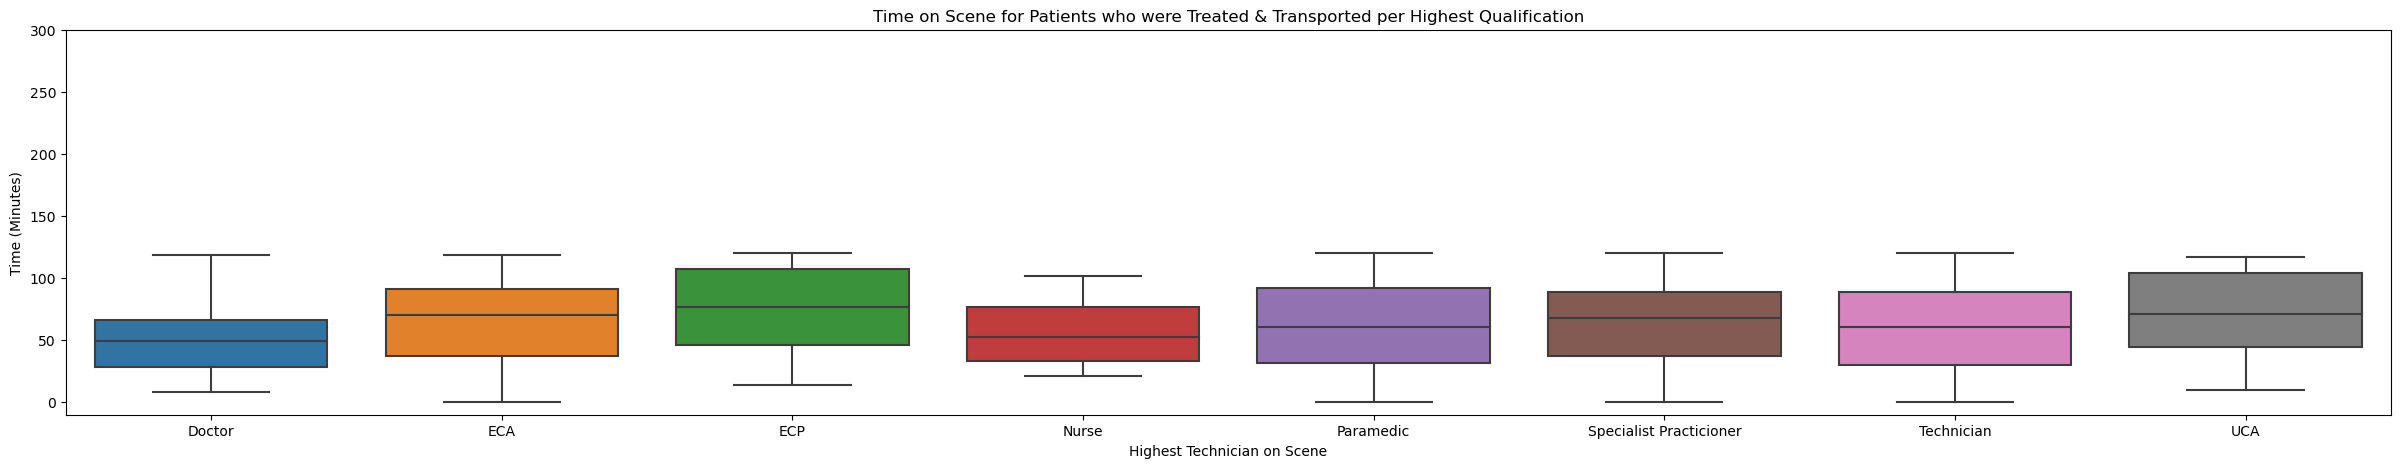

In [35]:
boxplot_time_between_activities_per_attribute(EL_df1,'Arrive_scene','Depart_scene','Highest Technician on Scene','Treated & Transported','Time on Scene for Patients who were Treated & Transported per Highest Qualification',-10,300)


We caclulate the mean effect on the mean time between the events for each category of the attribute

In [134]:
attributes_effect_on_mean_time_between_events(EL_df1,'Arrive_scene','Depart_scene','Highest Technician on Scene','Treated & Transported')

Mean Time betweenArrive_scene and Depart_scene was 61.209018567639255 minutes


,Highest Technician on Scene,Mean effect on mean time between Arrive_scene and Depart_scene (minutes)
4,ECP,12.066844
3,UCA,8.790981
5,ECA,5.849805
0,Specialist Practicioner,1.261067
2,Paramedic,0.334933
6,Technician,-1.112038
7,Nurse,-4.209019
1,Doctor,-10.334019


We observe the effect of the Highest Technician on Scene on the timing between the events. We also filter it to those patients that were referred to other medical treatement.

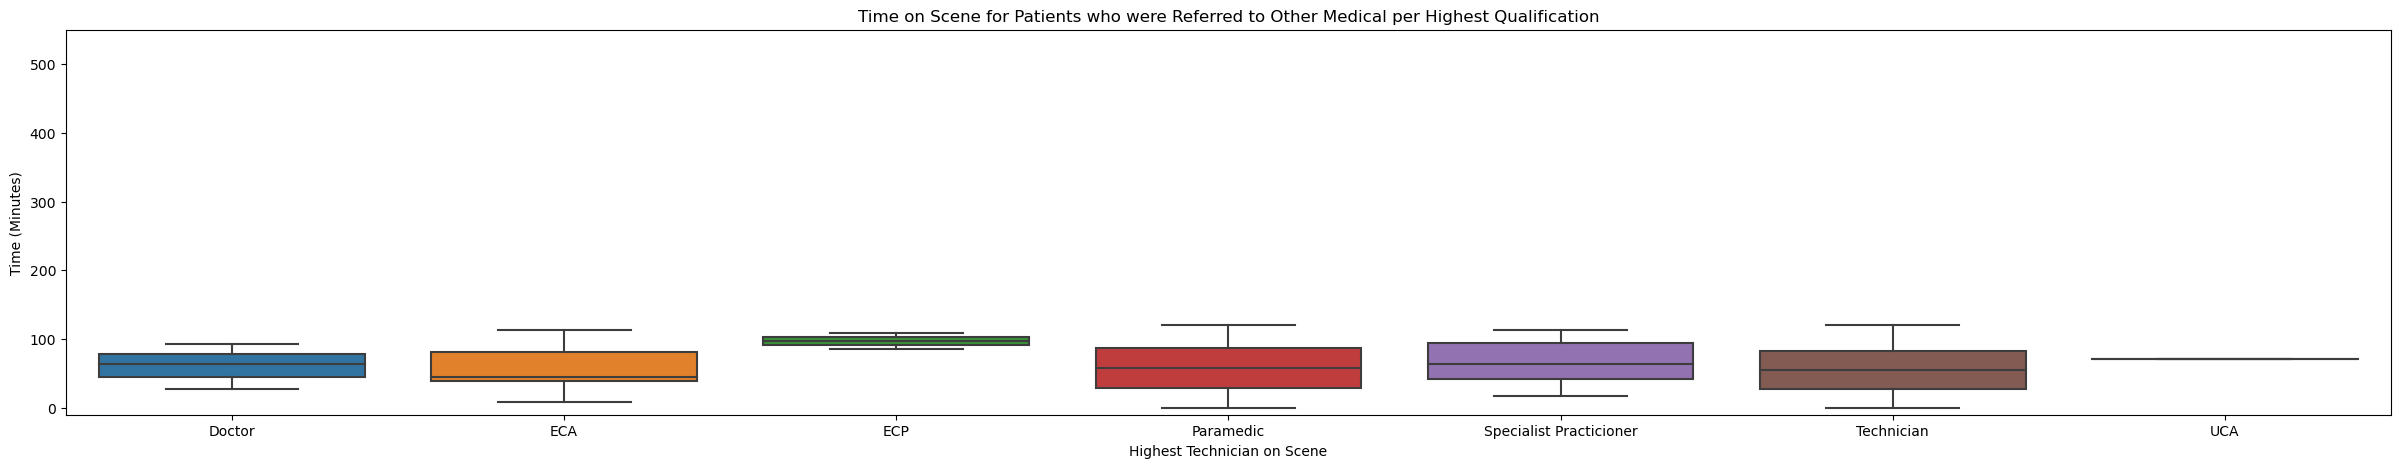

In [37]:
boxplot_time_between_activities_per_attribute(EL_df1,'Arrive_scene','Depart_scene','Highest Technician on Scene','Referred to Other Medical','Time on Scene for Patients who were Referred to Other Medical per Highest Qualification',-10,550)


We caclulate the mean effect on the mean time between the events for each category of the attribute

In [76]:
attributes_effect_on_mean_time_between_events(EL_df1,'Arrive_scene','Depart_scene','Highest Technician on Scene','Referred to Other Medical')

Mean Time betweenArrive_scene and Depart_scene was 58.31951640759931 minutes


,Highest Technician on Scene,Mean effect on mean time between Arrive_scene and Depart_scene (minutes)
4,ECP,38.680484
5,UCA,12.680484
0,Specialist Practicioner,8.621660
1,Doctor,3.013817
3,Paramedic,0.265976
2,ECA,-1.486183
6,Technician,-2.069516


We observe the effect of theIndex of Multiple Deprivation Decile on the timing between the events. We also filter it to those patients that were Treated & Transported.

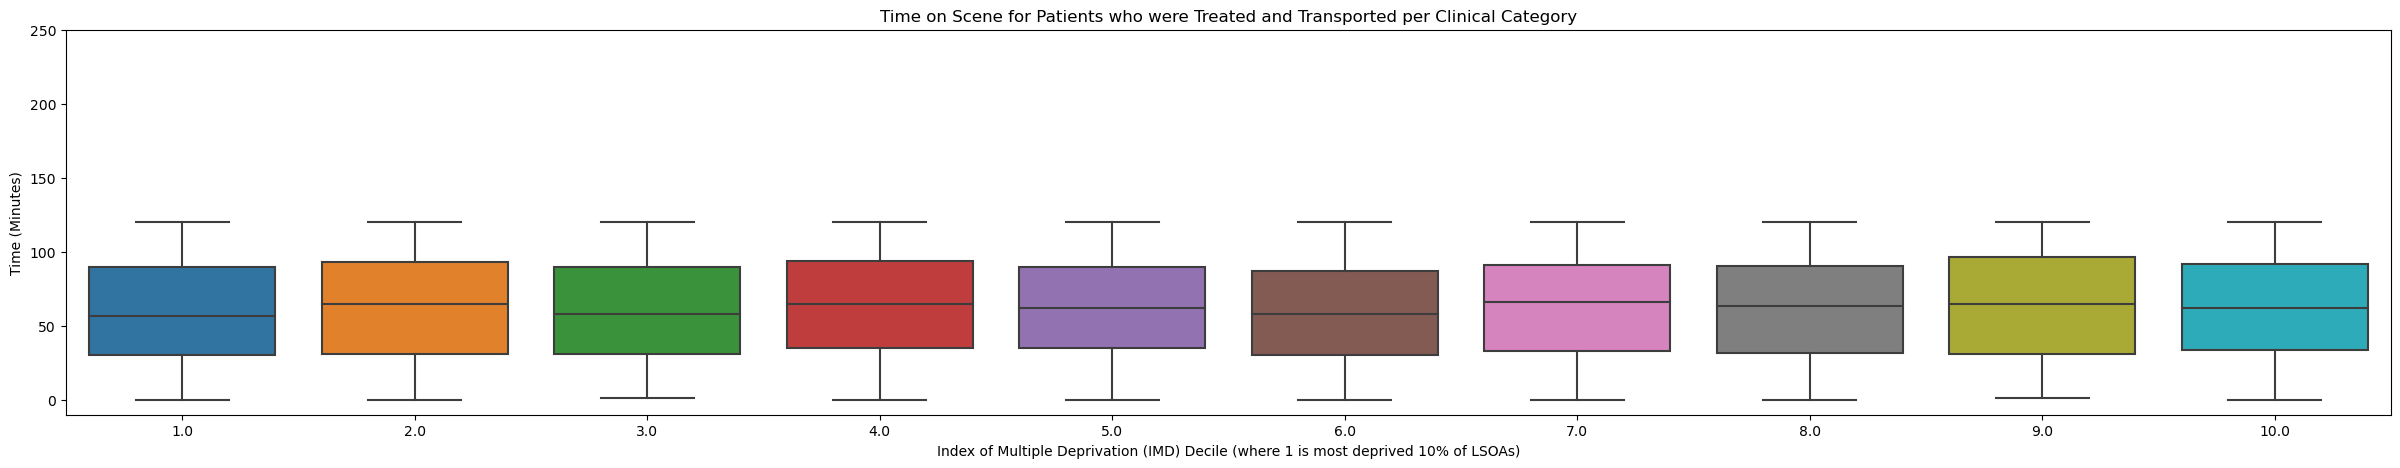

In [42]:
boxplot_time_between_activities_per_attribute(EL_df1,'Arrive_scene','Depart_scene','Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)','Treated & Transported','Time on Scene for Patients who were Treated and Transported per Clinical Category',-10,250)

We caclulate the mean effect on the mean time between the events for each category of the attribute

In [77]:
attributes_effect_on_mean_time_between_events(EL_df1,'Arrive_scene','Depart_scene','Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)','None')

Mean Time betweenArrive_scene and Depart_scene was 61.07254174397031 minutes


,Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Mean effect on mean time between Arrive_scene and Depart_scene (minutes)
8,9.0,3.077944
6,7.0,1.540835
9,10.0,1.139057
7,8.0,0.798986
1,2.0,0.508187
3,4.0,0.131780
5,6.0,-0.694578
4,5.0,-1.213822
0,1.0,-2.249249
2,3.0,-2.531864


### Arrive Destination to Care Transfer (Handover)

First we view the time density graph between the events.

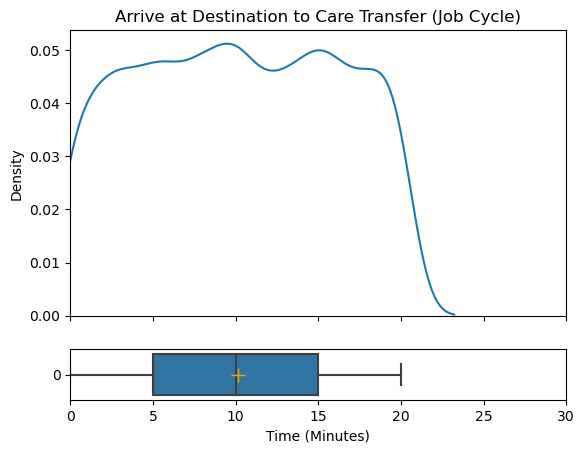

median time between events 10.0
mean time between events 10.163569457221712


(None, None)

In [142]:
timedensityandboxplot(EL_df1,'Arrive_dest','Care_transfer','Arrive at Destination to Care Transfer (Job Cycle)',30)

We observe the effect of the Cliniacl Category on the timing between the events. We also filter it to those patients that were Treated & Transported.

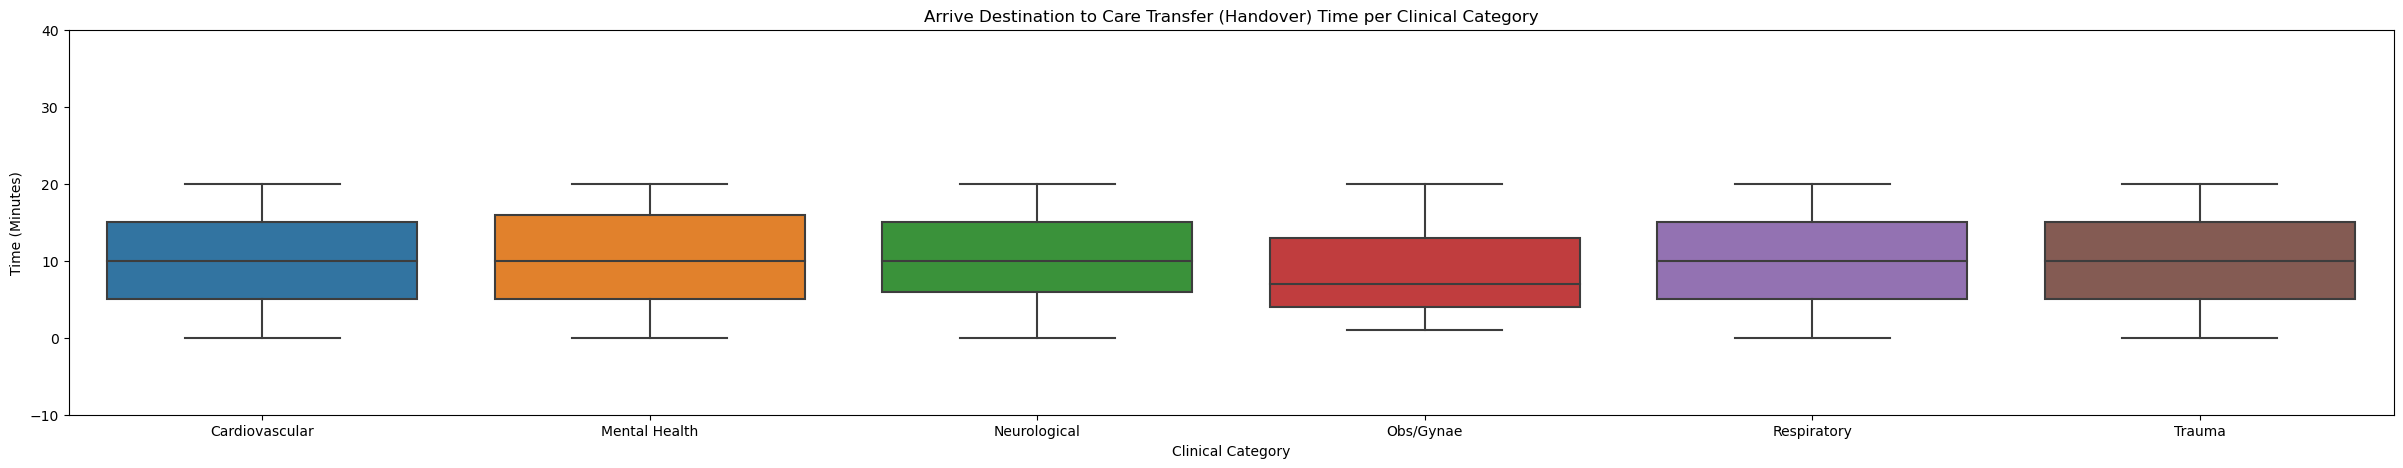

In [127]:
boxplot_time_between_activities_per_attribute(EL_df1,'Arrive_dest','Care_transfer','Clinical Category','Treated & Transported','Arrive Destination to Care Transfer (Handover) Time per Clinical Category',-10,40)

We caclulate the mean effect on the mean time between the events for each category of the attribute

In [137]:
attributes_effect_on_mean_time_between_events(EL_df1,'Arrive_dest','Care_transfer','Clinical Category','Treated & Transported')

Mean Time betweenArrive_dest and Care_transfer was 10.074535809018567 minutes


,Clinical Category,Mean effect on mean time between Arrive_dest and Care_transfer (minutes)
1,Neurological,0.128261
2,Mental Health,0.125464
4,Respiratory,0.076811
5,Cardiovascular,0.017672
0,Trauma,-0.240352
3,Obs/Gynae,-1.122155


We observe the effect of the day of the week on the timing between the events. We also filter it to those patients that were Treated & Transported.

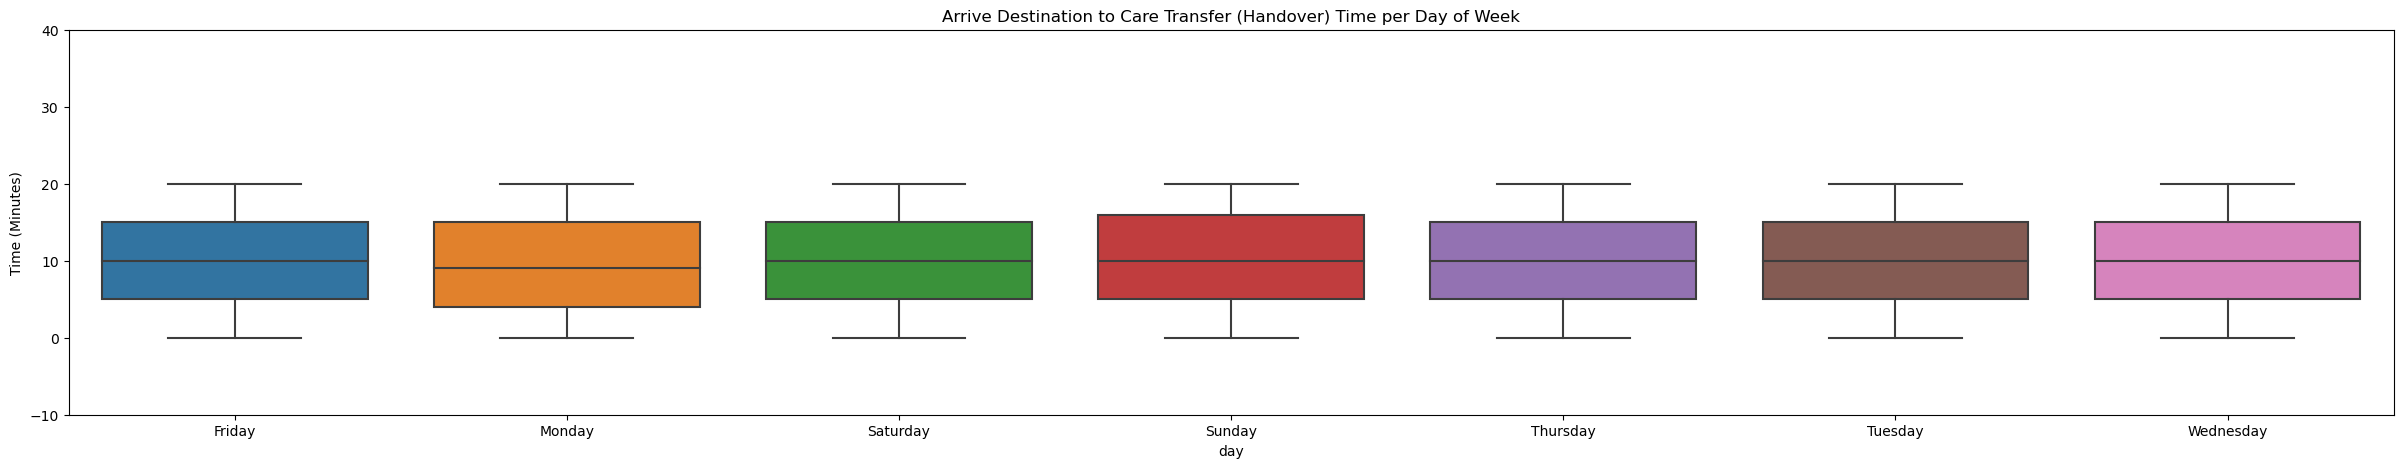

In [128]:
boxplot_time_between_activities_per_attribute(EL_df1,'Arrive_dest','Care_transfer','day','Treated & Transported','Arrive Destination to Care Transfer (Handover) Time per Day of Week',-10,40)

We caclulate the mean effect on the mean time between the events for each category of the attribute

In [138]:
attributes_effect_on_mean_time_between_events(EL_df1,'Arrive_dest','Care_transfer','day','Treated & Transported')

Mean Time betweenArrive_dest and Care_transfer was 10.074535809018567 minutes


,day,Mean effect on mean time between Arrive_dest and Care_transfer (minutes)
3,Sunday,0.391630
6,Friday,0.112527
1,Wednesday,0.092744
2,Thursday,0.038367
0,Tuesday,-0.189777
4,Saturday,-0.313474
5,Monday,-0.338117


## Linear Regression Model 

Using the attributes of the event log we can also try to predict the duratin of cases. here we make a linear regrssion model too predcit case duratin of an ambualnce job cycle frm atrubites in the eveent log.

Here we amke a data fraem consisting of the case ids, thier attribyes and their respective case duartions

In [97]:
lr_df=EL_df1[['Patient_ID','Highest Technician on Scene','Age','Sex', 'Event Location','Clinical Category','First NEWS',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
       'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)','hour', 'day', 'Arrive_on_Scene_Hour','Incident_Hour',
       'caselength']]

make one line for each patient with their associated attributes and drop patients that dont have a recoredd attribute

In [98]:
lr_df=lr_df.drop_duplicates(subset=['Patient_ID'],keep='first')
lr_df=lr_df.dropna()

categorise time

In [99]:
lr_df.loc[lr_df["hour"]<=8,"hourcat"]="morning"
lr_df.loc[(lr_df["hour"]>8) & (lr_df["hour"]<=18),"hourcat"]="day"
lr_df.loc[lr_df["hour"]>18,"hourcat"]="evening"

In [100]:
lrpatientids=list(lr_df.Patient_ID.values)
lry=list(lr_df.caselength.values)

In [101]:
X=lr_df[['Highest Technician on Scene','Age','Sex', 'Event Location','Clinical Category','First NEWS',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
       'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)','hour', 'day', 'Arrive_on_Scene_Hour','Incident_Hour',]]
Y=lr_df[['caselength']]

one hot encode variables

In [102]:
X=pd.get_dummies(X)
X

,Age,First NEWS,Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs),hour,Arrive_on_Scene_Hour,Incident_Hour,Highest Technician on Scene_Doctor,Highest Technician on Scene_ECA,...,Clinical Category_Obs/Gynae,Clinical Category_Respiratory,Clinical Category_Trauma,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,78,14,2.0,2.0,8.0,3,8,3,0,0,...,0,0,0,0,0,0,0,0,1,0
9,34,17,7.0,4.0,3.0,9,12,9,0,0,...,0,0,1,0,0,0,0,0,1,0
18,62,15,3.0,3.0,7.0,19,0,19,0,0,...,0,1,0,0,0,0,0,0,1,0
27,71,0,3.0,2.0,10.0,15,17,15,0,0,...,0,0,0,0,0,0,0,0,0,1
36,70,18,6.0,5.0,9.0,17,21,17,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48870,60,14,10.0,9.0,3.0,22,1,22,0,0,...,0,1,0,0,1,0,0,0,0,0
48879,4,0,6.0,9.0,1.0,10,14,10,0,0,...,0,0,0,0,0,0,1,0,0,0
48888,36,4,4.0,4.0,7.0,17,23,17,0,0,...,0,0,0,0,1,0,0,0,0,0
48897,75,16,8.0,7.0,4.0,16,20,16,0,0,...,0,1,0,0,0,0,1,0,0,0


build model

In [103]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()

In [104]:
model.fit(X,Y)

LinearRegression()

R2 score of model

In [105]:
model.score(pd.get_dummies(X),Y)

0.00443542350145143

Intercept of model in minutes

In [106]:
model.intercept_/60

array([440.42385693])

Coefficients of features, we can read this as the estimated number of minutes added to duratin of the case per intger increment in the respective attribute.

In [107]:
FI={'Feature':[i for i in X.columns],'Coefficients':[i/60 for i in model.coef_[0]]}
FI_df = pd.DataFrame(FI)
FI_df=FI_df.sort_values('Coefficients',axis=0, ascending=False)
FI_df.head(60)

,Feature,Coefficients
9,Highest Technician on Scene_ECA,17.825115
11,Highest Technician on Scene_Nurse,17.593022
8,Highest Technician on Scene_Doctor,10.396418
15,Highest Technician on Scene_UCA,6.801713
24,Clinical Category_Respiratory,6.183436
30,day_Thursday,4.698532
19,Event Location_Not Home,3.201938
27,day_Monday,2.432897
32,day_Wednesday,2.276540
21,Clinical Category_Mental Health,2.176822
